<a href="https://colab.research.google.com/github/CrisisDirector/learnopencv/blob/master/package_contents_predictions.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Problem Statement**

Predict the contents of a package from its dimensions and other visible features. This is useful as a failover in the event the package barcode is damaged or for some other reason unable to be scanned to verify the contents of the package.


# **Problem Solving Approaches**

1.   Currently decided to implement a multi-class classifier using certain features to predict package contents based on past data about package features and contents
2.   Many open-source tools are available to implement this
3.   Computer vision tools aren't needed, but can be implemented if there is scope and performance benefit to doing so
4.   No plans to use computer vision at the moment


# **Features Involved**

1. length (numeric) - measured by OAK-D camera
2. breadth (numeric) - measured by OAK-D camera
3. height (numeric) - measured by OAK-D camera
4. colour_code (multi-class) - detected by OAK-D camera
5. fragile (boolean) - detected by OAK-D camera


# **Target Variable**

**contents (multi-class)** -> predict contents of box scanned by OAK-D camera

# **Finding Dimensions**

* Calculate the pixel size of the image using the camera
* Then, knowing the focal length, resolution of the camera, as well as its distance from the package itself, calculate the actual dimensions of the package
* Authenticate the calculated dimensions with physically measured object dimensions for good measure  

Python code for the same is given below


In [ ]:
def find_physical_dimensions(pixels, focal_length, resolution, distance):

  """
  FUNCTION
  calculate the physical dimensions of the object from pixel dimensions of the image

  PARAMETERS
  pixels (int[2]): dimensions of the image in pixels; length, breadth, and height
  focal_length (float): the focal length of the camera in metres
  resolution (float): the resolution of the camera in metres per pixel
  distance (float): the distance of the package from the camera in metres

  RETURN VALUES
  metres (float[2]): dimensions of the package in metres; length, breadth, and height
  """

  return [(distance * pixels[i] * resolution / focal_length) for i in range(2)]

Sample code to validate the proper working of the function above:

In [ ]:
# currently using sample values, ingestion of actual values from data sources to be implemented when data sources are integrated

dimensions = [3.2, 2.1] # in metres

camera_specs = {"focal length": 0.1, "resolution": 0.0002}
distance = 1.5

captured_dimensions = [1066.67, 700.00] # in pixels

dim = ["length", "breadth"]
for i in range(2):
  print("Measured " + dim[i] + ": " + str(dimensions[i]))
  print("Calculated " + dim[i] + ": " + str(find_physical_dimensions(captured_dimensions, camera_specs["focal length"], camera_specs["resolution"], distance)[i]))

Measured length: 3.2
Calculated length: 3.2000100000000002
Measured breadth: 2.1
Calculated breadth: 2.1


The function has been implemented properly, and is ready to ingest data  from the edge devices involved

# **OAK-D camera hardware specifications**

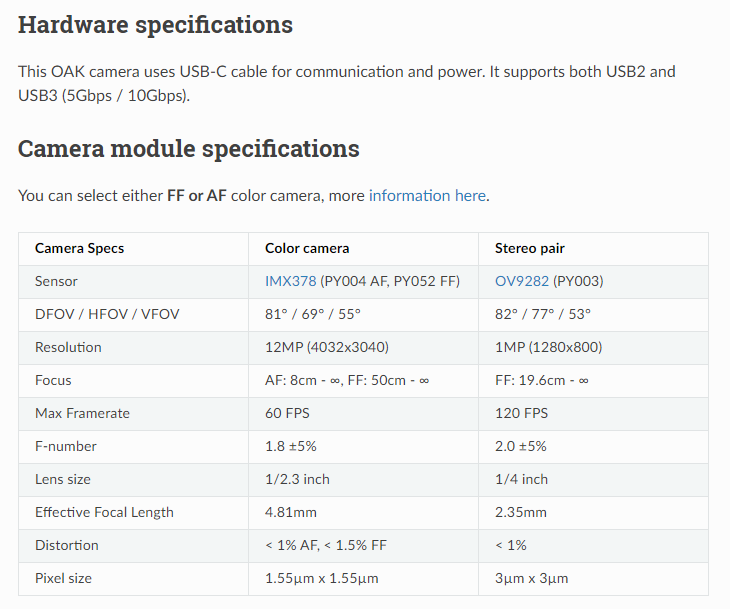

# **OAK-D API demo**

sample code to interact with depthAI, the OAK-D API

In [ ]:
pip install depthai

Note: you may need to restart the kernel to use updated packages.


In [ ]:
pip install cv2

Note: you may need to restart the kernel to use updated packages.


ERROR: Could not find a version that satisfies the requirement cv2 (from versions: none)
ERROR: No matching distribution found for cv2


In [ ]:
import cv2
import depthai as dai
import numpy as np

def getFrame(queue):
    # Get frame from queue
    frame = queue.get()
    # Convert frame to OpenCV format and return
    return frame.getCvFrame()

def getMonoCamera(pipeline, isLeft):
    # Configure mono camera
    mono = pipeline.createMonoCamera()

    # Set Camera Resolution
    mono.setResolution(dai.MonoCameraProperties.SensorResolution.THE_400_P)

    if isLeft:
        # Get left camera
        mono.setBoardSocket(dai.CameraBoardSocket.LEFT)
    else :
        # Get right camera
        mono.setBoardSocket(dai.CameraBoardSocket.RIGHT)
    return mono

if __name__ == '__main__':

    # Define a pipeline
    pipeline = dai.Pipeline()

    # Set up left and right cameras
    monoLeft = getMonoCamera(pipeline, isLeft = True)
    monoRight = getMonoCamera(pipeline, isLeft = False)

    # Set output Xlink for left camera
    xoutLeft = pipeline.createXLinkOut()
    xoutLeft.setStreamName("left")

    # Set output Xlink for right camera
    xoutRight = pipeline.createXLinkOut()
    xoutRight.setStreamName("right")

    # Attach cameras to output Xlink
    monoLeft.out.link(xoutLeft.input)
    monoRight.out.link(xoutRight.input)

    # Pipeline is defined, now we can connect to the device
    with dai.Device(pipeline) as device:

        # Get output queues.
        leftQueue = device.getOutputQueue(name="left", maxSize=1)
        rightQueue = device.getOutputQueue(name="right", maxSize=1)

        # Set display window name
        cv2.namedWindow("Stereo Pair")
        # Variable use to toggle between side by side view and one frame view.
        sideBySide = True

        while True:
            # Get left frame
            leftFrame = getFrame(leftQueue)
            # Get right frame
            rightFrame = getFrame(rightQueue)

            if sideBySide:
                # Show side by side view
                imOut = np.hstack((leftFrame, rightFrame))
            else :
                # Show overlapping frames
                imOut = np.uint8(leftFrame/2 + rightFrame/2)

            # Display output image
            cv2.imshow("Stereo Pair", imOut)

            # Check for keyboard input
            key = cv2.waitKey(1)
            if key == ord('q'):
                # Quit when q is pressed
                break
            elif key == ord('t'):
                # Toggle display when t is pressed
                sideBySide = not sideBySide

# **Obtain object dimensions using selected object detection model on OAK-D camera**

In [ ]:
# first, install package dependencies
pip install roboflowoak

In [ ]:
from roboflowoak import RoboflowOak
import cv2
import time
import numpy as np

if __name__ == '__main__':
    # instantiating an object (rf) with the RoboflowOak module
    rf = RoboflowOak(model = "box_3009_white", confidence = 0.05, overlap = 0.5,
    version = "15", api_key = "I6cUgrYxivD8Hvnz3lUB", rgb = True,
    depth = True, device = None, blocking = True)
    # Running our model and displaying the video output with detections
    while True:
        t0 = time.time()
        # The rf.detect() function runs the model inference
        result, frame, raw_frame, depth = rf.detect(visualize=True)
        predictions = result["predictions"]
        #{
        #    predictions:
        #    [ {
        #        x: (middle),
        #        y:(middle),
        #        width:
        #        height:
        #        depth: ###->
        #        confidence:
        #        class:
        #        mask: {
        #    ]
        #}
        #frame - frame after preprocs, with predictions
        #raw_frame - original frame from your OAK
        #depth - depth map for raw_frame, center-rectified to the center camera

        # timing: for benchmarking purposes
        t = time.time()-t0
        print("INFERENCE TIME IN MILLISECONDS: ", 1/t)
        print("PREDICTIONS (JSON): ", [p.json() for p in predictions])

        print("Dimensions: ", [(p["width"], p["height"]) for p in predictions])

        # setting parameters for depth calculation
        max_depth = np.amax(depth)
        cv2.imshow("depth", depth/max_depth)
        # displaying the video feed as successive frames
        cv2.imshow("frame", frame)

        # how to close the OAK inference window / stop inference: CTRL+q or CTRL+c
        if cv2.waitKey(1) == ord('q'):
            break

# **Designing the contents prediction classifier**

1. Import dependencies and load pre-existing package contents data

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

# Load the dataset
carton_data = pd.read_csv('carton_dataset.csv')

2. Separate target from features and convert categoricals into numbers for the model to work with

In [ ]:
# Convert categorical variables to numerical
labelencoder = LabelEncoder()
carton_data['color'] = labelencoder.fit_transform(carton_data['color'])
carton_data['fragile'] = labelencoder.fit_transform(carton_data['fragile'])

# Split the dataset into features and target variable
X = carton_data.iloc[:, :-1].values
y = carton_data.iloc[:, -1].values

# Split the dataset into training and testing set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 0)

3. Train and test the classifier (a decision tree classifier is used here)

In [ ]:
# Create a decision tree classifier
classifier = DecisionTreeClassifier()

# Train the classifier
classifier.fit(X_train, y_train)

# Print performance report for training data
train_pred = classifier.predict(X_train)
print("Training Performance Report:")
print(classification_report(y_train, train_pred))

# Print performance report for testing data
test_pred = classifier.predict(X_test)
print("Testing Performance Report:")
print(classification_report(y_test, test_pred))

4. Use the model to make predictions for new cartons

In [ ]:
# Predict the contents of new cartons
new_carton = [[10, 20, 2, 1]] # width, height, color, fragile
predicted_content = classifier.predict(new_carton)
print("Predicted content:", predicted_content)

# **High Level Solution Overview**



1. The camera detecting the boxes is positioned facing their broadside, at a fixed distance away from where the boxes are passing through
2. The camera detects the boxes using the object detection model loaded into it and measures their dimensions using its own capabilities
3. Another camera can be used to detect the presence of fragile sticker or other features being evaluated
4. These features are fed into the classifier
5. If the barcode is working, the contents of the box are also sent to the classifier and added to its training dataset
6. If the barcode is faulty, the classifier uses its data to predict what the box contains

